<a href="https://colab.research.google.com/github/kywch/geo-colab/blob/master/TreePedia_Step1_point_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This function will parse throigh the street network of provided city and     clean all highways and create points every mini_dist meters (or as specified) along the linestrings 

Required modules: Fiona and Shapely

parameters:
* inshp: the input linear shapefile, must be in WGS84 projection, ESPG: 4326
* output: the result point feature class
* mini_dist: the minimum distance between two created point

Source: https://github.com/mittrees/Treepedia_Public/blob/master/Treepedia/createPoints.py, last modified by Xiaojiang Li, MIT Senseable City Lab


OSM examples: https://github.com/gboeing/osmnx-examples/tree/master/notebooks


In [1]:
!apt install python3-rtree
!pip install geopandas
!pip install osmnx

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [1]:
import fiona
import os,os.path
from shapely.geometry import shape,mapping
from shapely.ops import transform
from functools import partial
import pyproj
from fiona.crs import from_epsg

import osmnx as ox
import matplotlib.pyplot as plt


In [10]:
place_name = "Hyde Park, Chicago, Illinois, USA"

graph = ox.graph_from_place(place_name, network_type='walk')

In [14]:
graph = ox.project_graph(graph, to_crs=pyproj.CRS('EPSG:4326'))
ox.save_graph_shapefile(graph, filepath='./source')

In [11]:
!ls source

clean_edges.cpg  clean_edges.shx  edges.shp  nodes.prj	      sampled_20m.dbf
clean_edges.dbf  edges.cpg	  edges.shx  nodes.shp	      sampled_20m.prj
clean_edges.prj  edges.dbf	  nodes.cpg  nodes.shx	      sampled_20m.shp
clean_edges.shp  edges.prj	  nodes.dbf  sampled_20m.cpg  sampled_20m.shx


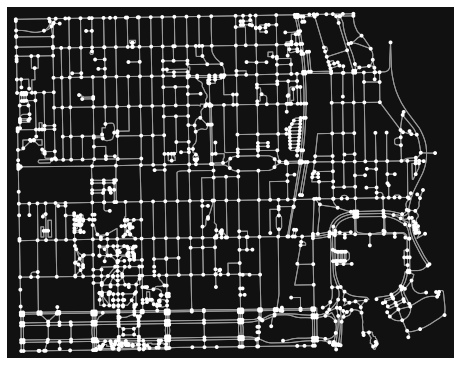

<Figure size 432x288 with 0 Axes>

In [5]:
fig, ax = ox.plot_graph(graph)
plt.tight_layout()

In [6]:
inshp = 'source/edges.shp'
root = os.path.dirname(inshp)
basename = 'clean_' + os.path.basename(inshp)
temp_cleanedStreetmap = os.path.join(root,basename)

print(temp_cleanedStreetmap)

source/clean_edges.shp


In [12]:
with fiona.open(inshp) as source:
  print(len(source))

print(source.crs)

2057
None


In [13]:
passed = 0
s = {'trunk_link','tertiary','motorway','motorway_link','steps', None, ' ','pedestrian','primary', 'primary_link','footway','tertiary_link', 'trunk','secondary','secondary_link','tertiary_link','bridleway','service'}    

# clean the original street maps by removing highways, if it the street map not from Open street data, users'd better to clean the data themselve
with fiona.open(inshp) as source, fiona.open(temp_cleanedStreetmap, 'w', driver=source.driver, crs=source.crs, schema=source.schema) as dest:
    
  print('source length: ', len(source))

  for feat in source:
    try:
      i = feat['properties']['highway'] # for the OSM street data
      if i in s:
        continue
    except:
      # if the street map is not osm, do nothing. You'd better to clean the street map, if you don't want to map the GVI for highways
      key = dest.schema['properties'].keys()[0] # get the field of the input shapefile and duplicate the input feature
      i = feat['properties'][key]
      if i in s:
        continue

    passed += 1
    dest.write(feat)

print('after filtering: ', passed)

TypeError: ignored

In [9]:
# sampled points schema

mini_dist = 20 # meters

schema = {
  'geometry': 'Point',
  'properties': {'id': 'int'},
}

In [ ]:
outshp = os.path.join(root,'sampled_20m.shp')

count = 0
  
# Create pointS along the streets
with fiona.drivers():
  #with fiona.open(outshp, 'w', 'ESRI Shapefile', crs=source.crs, schema) as output:
  with fiona.open(outshp, 'w', crs = from_epsg(4326), driver = 'ESRI Shapefile', schema = schema) as output:
    for line in fiona.open(temp_cleanedStreetmap):
      first = shape(line['geometry'])
      
      length = first.length
      
      try:
        # convert degree to meter, in order to split by distance in meter
        #project = partial(pyproj.transform,pyproj.Proj(init='EPSG:4326'),pyproj.Proj(init='EPSG:3857')) #3857 is psudo WGS84 the unit is meter
        project = partial(pyproj.transform,pyproj.CRS('EPSG:4326'), pyproj.CRS('EPSG:3857')) #3857 is psudo WGS84 the unit is meter
        
        line2 = transform(project, first)
        linestr = list(line2.coords)
        dist = mini_dist #set
        for distance in range(0,int(line2.length), dist):
          point = line2.interpolate(distance)
          
          # convert the local projection back the the WGS84 and write to the output shp
          project2 = partial(pyproj.transform,pyproj.CRS('EPSG:3857'), pyproj.CRS('EPSG:4326'))
          point = transform(project2, point)
          output.write({'geometry':mapping(point),'properties': {'id':1}})

      except:
        print ("You should make sure the input shapefile is WGS84")
      
      count += 1
      if (count % 100 == 0):
        print('processed ', count, ' lines ...')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FionaDeprecationWarning: Use fiona.Env() instead.
  


You should make sure the input shapefile is WGS84
You should make sure the input shapefile is WGS84
You should make sure the input shapefile is WGS84
You should make sure the input shapefile is WGS84
You should make sure the input shapefile is WGS84
You should make sure the input shapefile is WGS84
You should make sure the input shapefile is WGS84
You should make sure the input shapefile is WGS84
